<h1> Control de loudness en tiempo real</h1>

<h2>Introduccion proyecto</h2>

En este documento se explicaran los desarrollos realizados para conseguir un control automatico de loudness de una señal sonora en tiempo real. En esta primer aproximacion el desarrollo es llevado a cabo en python, sin embargo se espera mas adelante poder bajar este algoritmo y sus resultados a un microcontrolador.
El objetivo es poder cuantificar el nivel de loudness de una señal de manera representativa para el oido humano y poder en base a dicha medicion ajustar el nivel sonoro para acerlo agradable a la persona. El ajuste de nivel de loudness no debe ser destructivo para la señal, es decir se busca tener la menor distorcion posible.
A lo largo de este documento se mostraran los distintos pasos y desarrollos realizados y que resultados se obtuvieron en cada caso.

<h2>Medicion Loudness</h2>

El nivel de loudness de una señal se refiere a la percepción subjetiva de la intensidad o volumen de un sonido por parte de un oyente. En otras palabras, es la medida de cuán fuerte o suave se escucha una señal de audio en función de cómo la percibe el oído humano. El loudness no se mide directamente en decibelios (dB), como lo haría el nivel de presión sonora, sino que tiene en cuenta la sensibilidad del oído humano a diferentes frecuencias y ajusta la medición en consecuencia. 

Para poder medir dicha magntiud nos basamos en la norma ITU-R BS.1770, que se emplea en la industria de la radiodifusión y el audio para video.La unidad de medida de esta norma son los LKFS (loudness k-weight relative to full scale) y se cumple una relacion 1 a 1 con el dB. A continuacion se mostraran todos los pasos del algoritmo que requiere para determinar el loudness.

<h3>Diagrama en bloques</h3>

Este diagrama representa el procedimiento que se realiza a la señal de hasta 5 canales de audio para poder deteminar el nivel de loudness

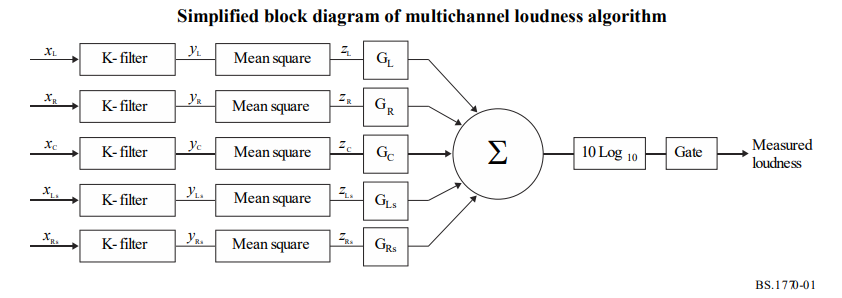

<h3>Filtrado de entrada</h3>

La norma indica que para poder medir el nivel de loudness, primero es necesario aplicar un filtrado a la señal para poder acentuar o disminuir aquellas frecuencias que el oido humano escucha con mayor o menor facilidad. Por ello dos filtros son aplicados a la señal:

* Sensibilidad del oido humano

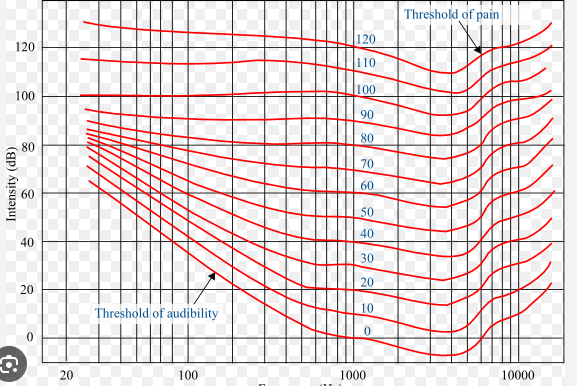

* Filtro para compensar el efecto acustico de la cabeza

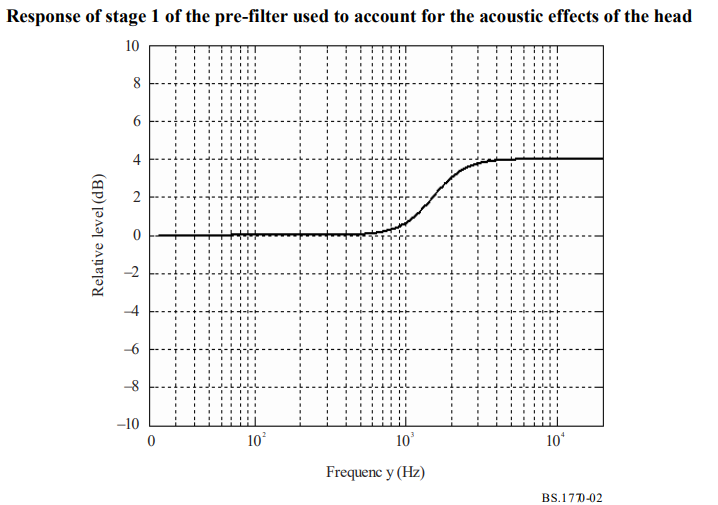

* Filtro de "peso" para las frecuencias segun el oido humano

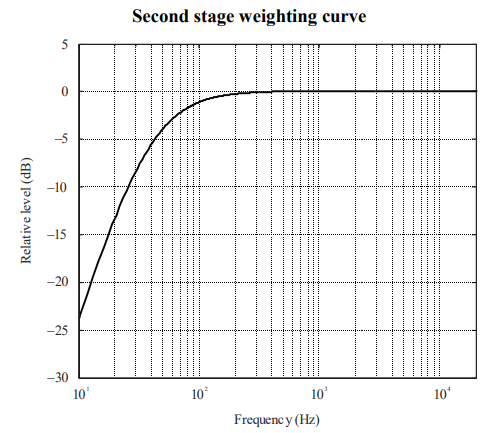


Para ambos filtros, la norma proporsiona los coeficientes de filtros del tipo IIR de segundo orden calculados para una frecuencia de muestreo 48Khz. Es importante remarcar que si se desea cambiar la frecuencia de muestreo es necesario recalcular estoss coeficientes.

Los coeficientes son:

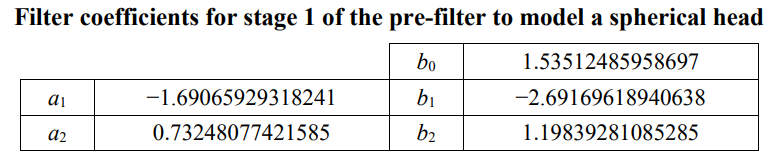

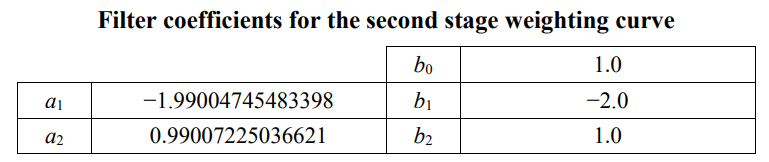

<h3>Media cuadrada (Calculo de potencia)</h3>

Una vez acondisionada la señal de entrada, se procede a calcular la potencia de la señal. Para ello sabemos que se puede determinar la potencia de una señal "yi" de periodo "T" como:

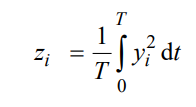

donde la "i" representa el numero de canal pudiendo ser hasta como maximo 5 canales (Izquierdo, derecho, central, surround izquierdo, surround derecho).

Es importante a estas alturas conocer que el loudness puede ser determinado de dos maneras, una es medido respecto de todo el intervalo T de la señal y otro es forma "Gated":

<u>Gated Loudness Measurement (Medición de Loudness con Ventana de Apertura)</u>:

Definición: En el método de Gated Loudness Measurement, se utiliza una ventana de apertura (gating window) para determinar cuándo se mide el loudness y cuándo se ignora. Solo se mide el loudness cuando la señal supera cierto umbral (threshold) durante el período de la ventana de apertura.
Uso: Este método se utiliza para medir el loudness de partes específicas de una señal de audio, generalmente ignorando partes silenciosas o de fondo. Es útil para evitar que segmentos silenciosos o no relevantes afecten el cálculo del loudness global.
Ejemplo de Aplicación: Puede utilizarse en la medición de loudness de comerciales publicitarios, donde solo se mide el loudness durante el tiempo en que el anuncio está activo y se ignora cuando no está en el aire.

<u>Loudness Over Interval T (Loudness en Intervalo de Tiempo T):</u>

Definición: El método de Loudness Over Interval T implica el cálculo del loudness promedio en un intervalo de tiempo específico (T). En este enfoque, se mide el loudness de toda la señal durante ese período y se promedia.
Uso: Este método se utiliza para obtener el loudness promedio de una señal de audio en un intervalo de tiempo continuo. Es útil para medir el loudness global a lo largo de una grabación o transmisión.
Ejemplo de Aplicación: Se utiliza en la medición de loudness de programas de televisión, películas y otros contenidos de audio para evaluar si cumplen con los estándares de loudness a lo largo de la duración completa del programa.

Por lo tanto podemos calcular el loudness respecto a un intervalo T como:

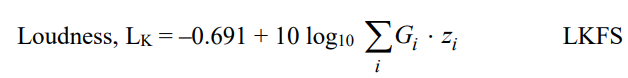

Donde Gi son un conjunto de coeficientes que se aplica a cada canal segun corresponda.

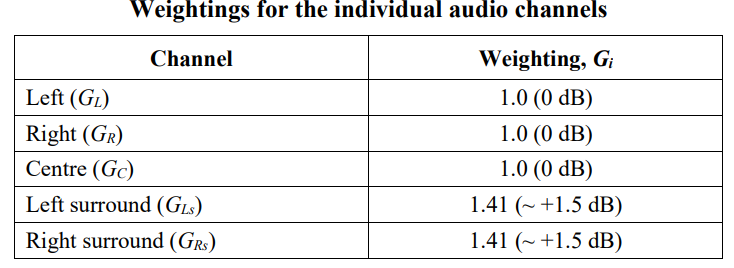

Para este proyecto sin embargo se adopto la tecnica de medicion de loudness de compuerta, ya que nos interesa determinar el loudness en partes reducidas del total de la señal. Recordemos que al estar en una aplicacion de tiempo real desconocemos que informacion nos va a llegar.

Para calcular el gated loudness, se divide a la señal de periodo T en ventanas de 0.4 segundos, donde cada ventana tendra una cantidad de muestras de la señal recibida.
Entre cada ventana debe haber un "overlap", es decir que entre una ventana y la siguiente se compartiran parte de las muestras de la señal de entrada. Con esto cada ventana tiene una cierta correlacion con las ventanas adyacentes.
La norma indica que el overlap debe ser del 75%.
Se calcula entonces la potencia de cada ventana por separado de la siguiente manera:

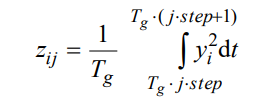

Donde: 

step = 1 - overlap

y ademas

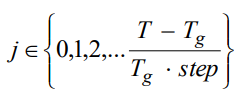

Esta ultima expresion nos da idea de la cantidad de ventanas que tendra una señal segun el periodo "T" que tenga.

Una vez calculada la potencia de cada una de las ventanas se procede a calcular el loudness de cada una de ellas como:

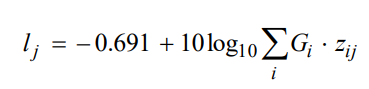

Donde:

j: representa el numero de ventana
i: representa el numero de canal

Una vez determinado el loudness de cada ventana es necesario filtrar aquellas ventanas que simbolicen silencio. Es decir si no se recibe ningun tipo de informacion no se debe considerar para determinar el loudness de la señal. Para ello se analizan los valores obtenido de loudness y se buscan aquellos que sean superiores a un valor de disparo (threshold). La norma indica que es adecuado tomar un nivel de disparo de -70LKFS.

Entonces filtrando aquellos valores inferiores obtenemos:

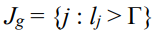

siendo Jg un vector de los indices de las ventanas que superan al nivel de disparo.

En este punto es bueno hacer una diferencia entre dos tipos de gated loudness:

<u>Medición de Loudness Absoluta (Absolute Loudness Measurement):</u>

Definición: La medición de loudness absoluta se refiere a la medición del nivel de loudness de una señal de audio en relación con una referencia absoluta, que generalmente se establece en 0 LUFS (Loudness Units Relative to Full Scale).
Uso: La medición de loudness absoluta se utiliza para determinar el loudness real o absoluto de una señal sin tener en cuenta otras señales de referencia. Es útil cuando necesitas conocer el nivel de loudness de una señal en sí misma sin considerar su relación con otras señales.
Ejemplo de Aplicación: En la producción de contenido de audio para medios de comunicación, como películas o programas de televisión, se utiliza la medición de loudness absoluta para asegurarse de que el loudness cumple con los estándares establecidos para una experiencia de escucha consistente.

<u>Medición de Loudness Relativa (Relative Loudness Measurement):</u>

Definición: La medición de loudness relativa se refiere a la medición del nivel de loudness de una señal en relación con una señal de referencia. La diferencia de loudness entre la señal de interés y la señal de referencia se expresa en LKFS (Loudness Units Relative to Full Scale).
Uso: La medición de loudness relativa es útil cuando necesitas comparar el loudness de una señal con respecto a otra. Se utiliza para evaluar la diferencia de loudness entre segmentos de audio o para asegurarse de que varias señales tengan niveles de loudness similares.
Ejemplo de Aplicación: En la transmisión de publicidad en televisión, se utiliza la medición de loudness relativa para asegurarse de que los anuncios publicitarios no sean significativamente más fuertes o más suaves que el contenido de programación.

Por lo tanto podemos calcular el loudness absoluto como:

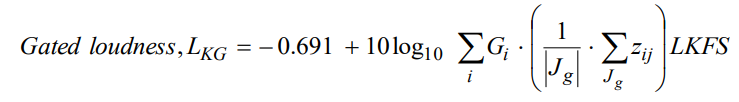

Siendo:
|Jg| : Cantidad de ventanas que superan el humbral.

Una vez obtenido el loudness absoluto podemos calcular el relativo. Para ello primero es conseguir un nuevo valor de disparo respecto del valor de loudness absoluto. Esto se hace para desestimar todas aquellas ventanas que se ven "tapadas" por las muestras de mayor peso.

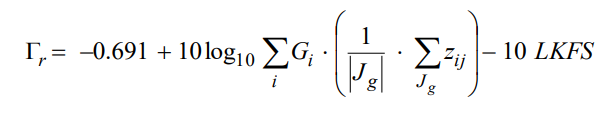

Nuevamente se buscan aquellas ventanas que superen este nivel y el indicado anteriormente:

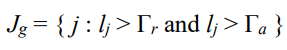

Jg es un vector que contendra los indices de las ventanas que si cumplen con los niveles de disparo calculados.

Finalmente podemos obtener el nivel de loudness relativo como:

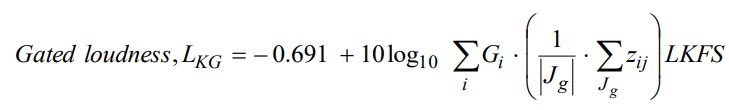

La norma nos proporsiona un ejemplo para poder comprobar el algoritmo y es que para una señal de 1Khz de 0db el loudness indicado debe ser de -3,01LKFS


<h2> Algoritmo de calculo para señales de un canal </h2>

Una primer aproximacion y que tiene un menor costo computacional es realizar el algoritmo para un unico canal de la señal, como por ejemplo el canal izquierdo.
El algoritmo resultante es el siguiente:


In [49]:
import numpy as np
from scipy.signal import lfilter
import warnings

def loudness_algoritmo(buffer,loudness_deseado,fs = 48000,Tg_f = 0.4): 
    '''
    Parameters
    ----------
    buffer : float
    Vector con datos de la señal de audio a procesar. 
    loudness_deseado : float 
        Loudness deseado en dB
    fs : frecuencia de muestreo, optional
        Frecuencia a la que fue muestreado el sistema. The default is 48000.
    Tg : float, optional
        Tiempo de compuerta. The default is 0.4'

    Returns
    Valor de loudness relativo al valor deseado.
    -------
    TYPE
        Funcion que recibe un buffer de "N" muestras a una frecuencia de muestreo "Fs"
        tiempo de gate y el loudness deseado. 
        Devuelve el loudness relativo respecto al loudness deseado
    '''
        
    ### Coeficientes de filtros
    num_preFilter= [1.53512485958697,-2.69169618940638,1.19839281085285]
    den_preFilter= [1,-1.69065929318241,0.73248077421585]

    num_weightingFilter= [1,-2,1]
    den_weightingFilter= [1,-1.99004745483398,0.99007225036621]

    ### Parametros para algoritmo
    
    T_f = len(buffer)/ fs ## Periodo completo de la señal
    overlap = 0.75
    step = 1 - overlap
    number_of_windows =int((T_f - Tg_f)/(Tg_f*step))  
    GI= [1,1,1,1.41,1.41] # coeficientes de los canales
    
    gama_a = -70 # LKFS
    
    ##Aplico filtros al buffer
    out = lfilter(num_preFilter, den_preFilter, buffer)
    out = lfilter(num_weightingFilter, den_weightingFilter, out)
     
    ## Calculo la potencia de cada ventana
    integral_ij = np.array([ np.sum(out[ int(Tg_f*fs*(j*step)) : int(Tg_f*fs*(j*step+1) + 1)]**2) for j in range(0,number_of_windows)]) 
    z_ij = (1/(Tg_f*fs)) * integral_ij
    
    ## Calculo el loudness de cada ventana
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_j = -0.691 + 10*np.log10( z_ij )
    
    ## Identifico muestras por encima del nivel minimo
    posiciones_validas = np.where(loudness_j > gama_a)
    
    ## Calculo el loudness absoluto
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_abs = -0.695 + 10* np.log10(np.sum(z_ij[posiciones_validas])/len(posiciones_validas[0])) 
    
    ## Calculo coeficiente para el calculo de loudness relativo
    gama_b = loudness_abs - 10
    
    ## Identifico muestras por encima del nivel minimo
    posiciones_validas = np.where(loudness_j > gama_b)
     
    ## Calculo el loudness Relativo
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_rel = -0.695 + 10* np.log10(np.sum(z_ij[posiciones_validas])/len(posiciones_validas[0])) - loudness_deseado
        
    return loudness_rel



In [7]:
#Comprobacion del algoritmo:

frecuencia = 1000  # Frecuencia en Hz (1 kHz)
duracion = 3     # Duración en segundos
sample_rate = 48000  # Sample rate en Hz (48 kHz)

# Crear un arreglo de tiempo
t = np.linspace(0, duracion, int(sample_rate * duracion), endpoint=False)

# Generar la señal senoidal de 0dB
señal = np.sin(2 * np.pi * frecuencia * t)

print(f"El nivel de loudness de la señal es: {round(loudness_algoritmo(señal,loudness_deseado = 0, fs = sample_rate,Tg_f = 0.4 ),2)} LKFS ")


El nivel de loudness de la señal es: -3.01 LKFS 


<h2>Aplicando medicion de loudness en tiempo real</h2>

El algoritmo mostrado permite calcular el nivel de loudness de una señal de periodo T. Sin embargo en tiempo real no sabemos cuanto va a ser el periodo de la señal ni tampoco que señal debemos analizar, por lo que no podemos aplicar el algoritmo a la señal completa.
Una primer idea seria calcular unicamente el loudness de una unica ventana (0,4seg) y basarse en este resultado. Sin embargo esto seria muy sencible a cambios abrutos en una cancion, por lo que es necesario tener analizar el nivel de las muestras que se reciben y compararlas con muestras pasadas para asi conseguir un nivel mas uniforme y representativo de la señal.
Ya que analizar el nivel de loudness por cada muestra recibida implicaria un costo computacional muy grande e inecesario, se opta por obtener el loduness por cada ventana de 0,4seg que se recibe.
Debido a que almacenar todas las muestras recibidas seria inviable y muy costoso en terminos de memoria, se utiliza un buffer circular donde se almacena un determinado tiempo que representa el T de nuestra señal.

In [14]:
# Audios que se analizan:

from IPython.display import Audio

# Reproduce el archivo MP3
print("Muestra de audio sin alterar")
Audio(filename='Muestras Audio/Muestra1 - 0db atenuacion.mp3')

Muestra de audio sin alterar


In [17]:
print("Muestra de audio con 2db de atenuacion")
Audio(filename='Muestras Audio/Muestra1 - 2db atenuacion.mp3')

Muestra de audio con 2db de atenuacion


In [18]:
print("Muestra de audio con 4db de atenuacion")
Audio(filename='Muestras Audio/Muestra1 - 4db atenuacion.mp3')

Muestra de audio con 4db de atenuacion


In [19]:
print("Muestra de audio con 6db de atenuacion")
Audio(filename='Muestras Audio/Muestra1 - 6db atenuacion.mp3')

Muestra de audio con 6db de atenuacion


In [20]:
print("Muestra de audio con 10db de atenuacion")
Audio(filename='Muestras Audio/Muestra1 - 10db atenuacion.mp3')

Muestra de audio con 10db de atenuacion


In [21]:
print("Muestra de audio con 20db de atenuacion")
Audio(filename='Muestras Audio/Muestra1 - 20db atenuacion.mp3')

Muestra de audio con 20db de atenuacion


Para los siguientes ejemplos se toma como referencia un tramo de una cancion. PAra poder tener de referencia se calcula el loudness real de toda la señal en su conjunto, es decir ya no se calcula en tiempo real sino que en T.


In [150]:
import numpy as np
from pydub import AudioSegment


# Ruta al archivo MP3 en la misma carpeta que el script
archivo_mp3 = "Muestras Audio/Muestra3 - 2db atenuacion.mp3"

# Carga el archivo MP3 usando pydub
audio = AudioSegment.from_mp3(archivo_mp3)

datos_audio = audio.split_to_mono()[0].raw_data

sample_rate = 48e3

# Definir el número de bytes por muestra (16 bits = 2 bytes)
bytes_por_muestra = audio.sample_width

# Crear una lista para almacenar las muestras de audio
muestras_de_audio = []

# Iterar a través de los datos brutos tomando cada muestra
for i in range(0, len(datos_audio), bytes_por_muestra):
    # Obtener los bytes que representan una muestra
    muestra_bytes = datos_audio[i:i + bytes_por_muestra]
    
    # Desempaquetar los bytes en un valor entero con signo
    muestra_entero = int.from_bytes(muestra_bytes, byteorder='little', signed=True)
    
    # Agregar la muestra a la lista
    muestras_de_audio.append(float(muestra_entero))

loudness = loudness_algoritmo(np.array(muestras_de_audio),loudness_deseado = 0)
print("Loudness Total:",round(loudness,2), "LKFS")



Loudness Total: 77.88 LKFS


In [70]:
import matplotlib.pyplot as plt
from collections import deque
from pydub import AudioSegment

def analyse_signal_realTime(name,loudness_target):
    
    Tg = 0.4 # tiempo de ventana
    T= 3 # Tiempo de buffer
    sample_rate = 48000  # Sample rate en Hz (48 kHz)
    
    audio = AudioSegment.from_mp3(name)

    frecuencia_muestreo = audio.frame_rate
    if frecuencia_muestreo != sample_rate:
        print(frecuencia_muestreo)
        return False

    bytes_por_muestra = audio.sample_width ## Cuanto bytes tiene cada muestra 

    duracion_total = audio.duration_seconds

    ### Buffer donde almaceno todos los samples
    size_buff = int( sample_rate * T )
    buffer = deque(maxlen= size_buff) 
    
    buffer_loudness = []
    
    i=0
    
    while i*Tg < duracion_total:

        # Corta el segmento de audio en 0.4 segundos (simulo el real time)
        segmento = audio[i*Tg*1000:(i+1)*Tg*1000]# extraigo una ventana de 0,4 segundos 

        i +=1

        muestra_bytes = segmento.split_to_mono()[0].raw_data

        for i2 in range(0, len(muestra_bytes), bytes_por_muestra): # Los datos son de 16bits y hay que guardarlos en un buffer

            # Desempaquetar los bytes en un valor entero con signo y Agregar la muestra a la lista
            buffer.append(float(int.from_bytes(muestra_bytes[i2:i2+bytes_por_muestra], byteorder='little', signed=True))) 

        ## No mido Loudness hasta que el buffer este lleno
        if len(buffer)< size_buff-1:
            continue

        loudnes_relativo = loudness_algoritmo(list(buffer),loudness_deseado = loudness_target)
        
        buffer_loudness.append(loudnes_relativo)
        
        #print(f"El valor de loudness rel={loudnes_relativo} ")

    time_captured = np.linspace(0,duracion_total,len(buffer_loudness))# en segundos
    
    return time_captured,buffer_loudness

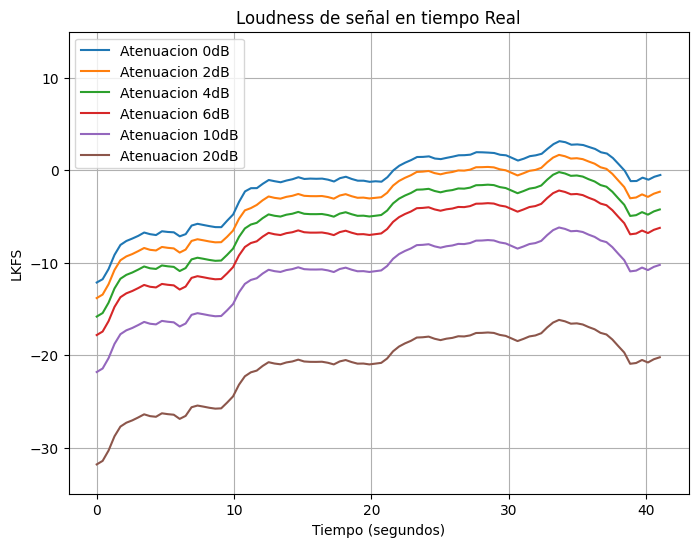

In [71]:

atenuaciones = [0, 2, 4, 6, 10 ,20]

plt.figure(figsize=(8, 6))  # Tamaño de la figura

for at in atenuaciones:

    time, data = analyse_signal_realTime(f"Muestras Audio/Muestra1 - {at}db atenuacion.mp3",loudness_target = 80.58 )

    # Graficar el vector buffer_gains en función del tiempo
    plt.plot(time, data, label=f'Atenuacion {at}dB')

plt.title('Loudness de señal en tiempo Real')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('LKFS')


# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.ylim(-35, 15)
plt.show()



Notar que el caso de 0dB es nuestra referencia, y podemos ver como luego del segundo 20 se estabiliza en el valor de 0dB de correccion. 
Al notamos una caida, sin embargo esto es propio de la cancion que empieza con un nivel bajo de volumen y aumenta progresivamente (fade in) tipico en el comienzo de las canciones

<h3>Ejemplo 2</h3>
A continuacion se muestra otro ejemplo de medicion, donde se tomo un tramo de una pista y se copio un 5 veces con distintos niveles de atenuacion

In [64]:
from IPython.display import Audio
print("Muestra de audio con atenuacion prograsiva (-3db por muestra)")
Audio(filename='Muestras Audio/Muestra2 - volume decrease.mp3')

Muestra de audio con atenuacion prograsiva (-3db por muestra)


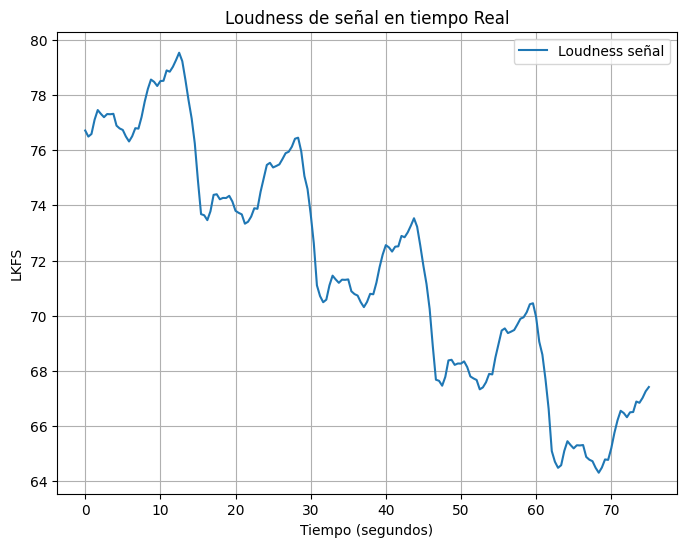

In [80]:
plt.figure(figsize=(8, 6))  # Tamaño de la figura

time, data = analyse_signal_realTime("Muestras Audio/Muestra2 - volume decrease.mp3",loudness_target = 0 )
plt.plot(time, data, label='Loudness señal')

plt.title('Loudness de señal en tiempo Real')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('LKFS')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

En este caso se puede notar la clara atenuacion de la señal y se puede indentificar que es de aproximandamente 3 dB de atenuacion. Sin embargo todavia no resulta posible con estos datos determinar una ganancia exacta que no distorcione la señal en los distintos puntos.

<h2>Correccion loudness Primer aproximacion</h2>

Una vez obtenido los valores de loudness se propone el siguiente diagrama para el sistema de correccion de loudness.

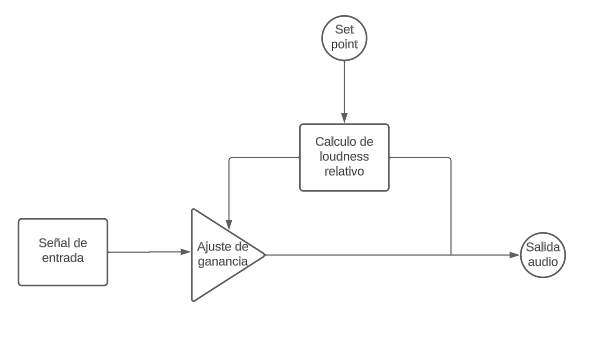

En donde la señal de entrada se afectara por una ganancia controlada por el resultado de la medicion de loudness respecto el valor objetivo.
A este metodo lo llamaremos "Directa"

In [133]:
## Funcion que analiza y corrige el loudness con distintos metodos para comparar resultados

def signal_realTime_Loudness_correction(name,loudness_target,algoritmo_correccion = ""):
    
    Tg = 0.4 # tiempo de ventana
    T= 3 # Tiempo de buffer
    sample_rate = 48000  # Sample rate en Hz (48 kHz)
    
    audio = AudioSegment.from_mp3(name)

    frecuencia_muestreo = audio.frame_rate
    if frecuencia_muestreo != sample_rate:
        print("La frecuencia de muestreo no es correcta: ", frecuencia_muestreo)
        return False

    bytes_por_muestra = audio.sample_width ## Cuanto bytes tiene cada muestra 

    duracion_total = audio.duration_seconds

    ### Buffer donde almaceno todos los samples
    size_buff = int( sample_rate * T )
    buffer = deque(maxlen= size_buff) 
    
    buffer_loudness = []
    
    i=0
    
    ## Preparo dato a devolver:
    resultado = {}  # Crea un diccionario vacío

    # Agrega elementos al diccionario
    
    resultado['Ganancias_Aplicadas'] = []
    resultado['Loudness_Relativo'] = []
    resultado['Loudness_Correccion'] = []
    resultado['Algoritmo'] = []
    
    gain = 0
    
    while i*Tg < duracion_total:

        # Corta el segmento de audio en 0.4 segundos (simulo el real time)
        segmento = audio[i*Tg*1000:(i+1)*Tg*1000] + gain  # extraigo una ventana de 0,4 segundos y le sube la ganancia "gain" dB

        i +=1

        muestra_bytes = segmento.split_to_mono()[0].raw_data

        for i2 in range(0, len(muestra_bytes), bytes_por_muestra): # Los datos son de 16bits y hay que guardarlos en un buffer

            # Desempaquetar los bytes en un valor entero con signo y Agregar la muestra a la lista
            buffer.append(float(int.from_bytes(muestra_bytes[i2:i2+bytes_por_muestra], byteorder='little', signed=True))) 

        ## No mido Loudness hasta que el buffer este lleno
        if len(buffer)< size_buff-1:
            continue

        loudness_relativo = loudness_algoritmo(list(buffer),loudness_deseado = loudness_target)
        
        ## Aca se aplicaran los distintos algoritmos de calculo de ganancia.
        if algoritmo_correccion == "Directa":
            gain += ((-loudness_relativo)) ## La ganancia esta en dB
        elif algoritmo_correccion == "DirectaLenta":
            K=10
            gain += ((-loudness_relativo)/K) ## La ganancia esta en dB
        elif algoritmo_correccion == "HistereticaLenta":
            K=10
            h = 5
            if abs(loudness_relativo) > h:
                gain += ((-loudness_relativo)/K) ## La ganancia esta en dB
        else:
            gain = 0
        ## Fin de algortimos
        resultado['Ganancias_Aplicadas'].append(gain)
        resultado['Loudness_Correccion'].append(loudness_relativo)
        resultado['Loudness_Relativo'].append(loudness_relativo + loudness_target)
        #print(f"El valor de loudness rel={loudnes_relativo} ")

    resultado['Tiempo'] = np.linspace(0,duracion_total,len( resultado['Loudness_Correccion']))# en segundos
    
    resultado['Algoritmo'] = algoritmo_correccion
    return resultado

In [140]:
#funcion que plotea la comparacion de distintos metodos de correccion

def plot_comparacion(name,graphs,analysis,loudness_target=0):
    response = []

    for anal in analysis:
        response.append(signal_realTime_Loudness_correction(name = name ,loudness_target = loudness_target ,algoritmo_correccion = anal ))
    for graph in graphs:
        plt.figure(figsize=(4, 3)) 
        if graph == "Loudness_Relativo":
                plt.title('Loudness de señal en tiempo Real')
                plt.xlabel('Tiempo (segundos)')
                plt.ylabel('LKFS')
        elif graph =="Ganancias_Aplicadas":
                plt.title('Ganancia aplicada')
                plt.xlabel('Tiempo (segundos)')
                plt.ylabel('dB')
        elif graph == "Loudness_Correccion" :
                plt.title('Loudness de señal en tiempo Real')
                plt.xlabel('Tiempo (segundos)')
                plt.ylabel('LKFS')
        for this_resp in response:
             plt.plot(this_resp['Tiempo'], this_resp[graph], label=this_resp['Algoritmo'])

        plt.grid(True)
        plt.legend()
        plt.show()



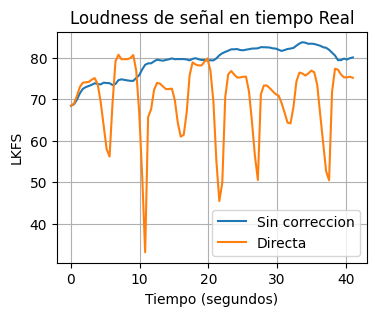

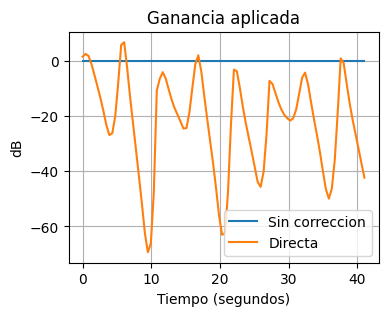

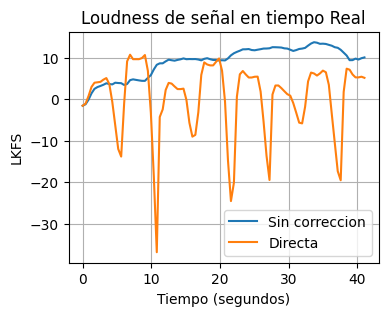

In [141]:
analysis = ["Sin correccion","Directa"]
graphs = ["Loudness_Relativo","Ganancias_Aplicadas","Loudness_Correccion"]
plot_comparacion("Muestras Audio/Muestra1 - 0db atenuacion.mp3",graphs,analysis,loudness_target = 70)

Ananlizando los resultados anteriores vemos que la respuesta del sistema no es muy buena. El problema que se nota es que la correccion de ganancia es instantanea lo cual implica una variacion bruzca en el volumen. Para corregir esto se plantea lo siguiente:

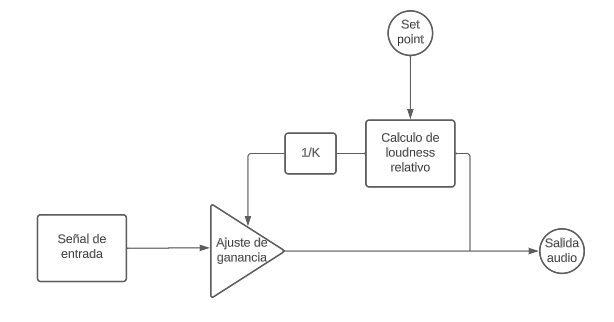

Siendo K una constante que permita reducir la velocidad de crecimiento de la ganancia. A este metodo lo llamaremos "DirectaLenta"
A continuacion se muestra el efecto con un K = 10

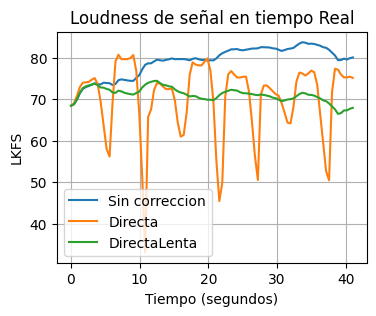

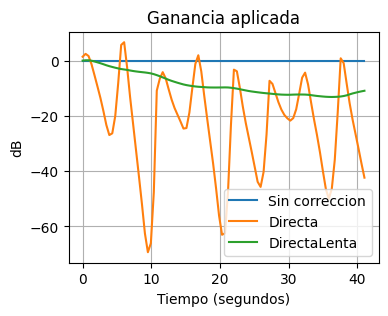

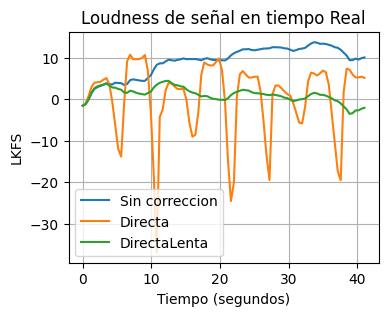

In [142]:
analysis = ["Sin correccion","Directa","DirectaLenta"]
graphs = ["Loudness_Relativo","Ganancias_Aplicadas","Loudness_Correccion"]
plot_comparacion("Muestras Audio/Muestra1 - 0db atenuacion.mp3",graphs,analysis,loudness_target = 70)

Vemos que el resultado es mejor, sin embargo se nota mucha distorcion en la señal. Esto se puede apreciar en como la respuesta original aumenta algunos dB cuando esta estabilizada y la respuesta corregida siempre atenua. Para corregir esto podemos plantear una histeresis al sistema de forma que una vez conseguido un equilibrio no varie la ganancia por aumentos pequeños de señal
El diagrama seria el siguiente:

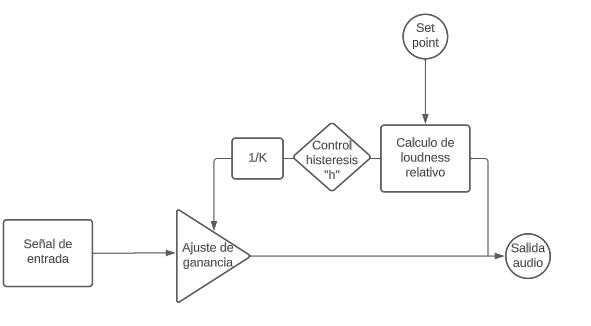

Donde "h" es el nivel de histeresis admisible por el sistema
A este modo lo llameremos correccion "HistereticaLenta". Para este ejemplo se usa un valor de h = 5dB

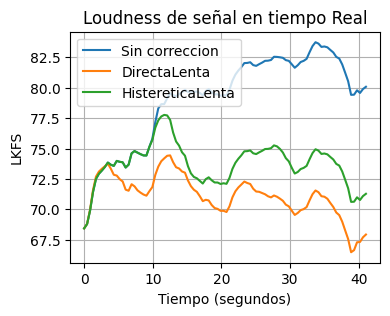

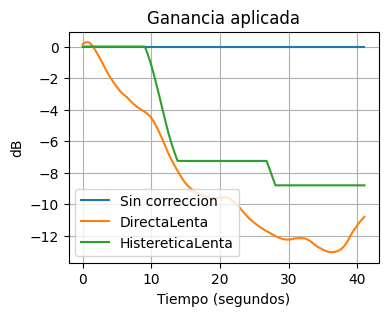

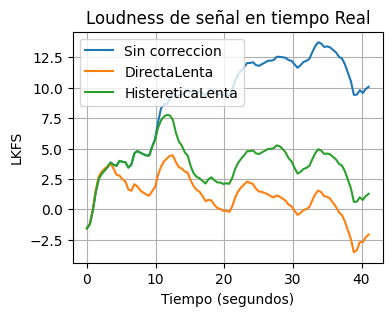

In [148]:
analysis = ["Sin correccion","DirectaLenta","HistereticaLenta"]
graphs = ["Loudness_Relativo","Ganancias_Aplicadas","Loudness_Correccion"]
plot_comparacion("Muestras Audio/Muestra1 - 0db atenuacion.mp3",graphs,analysis,loudness_target=70) ## Equivale a la señal origininal 6db atenuada

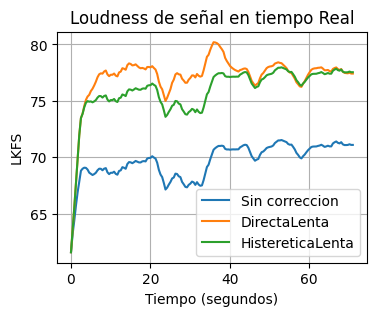

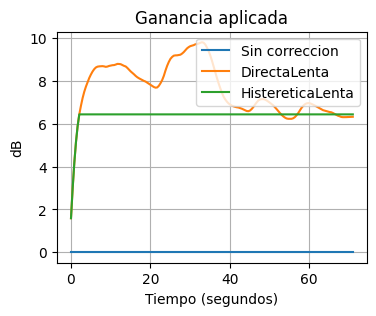

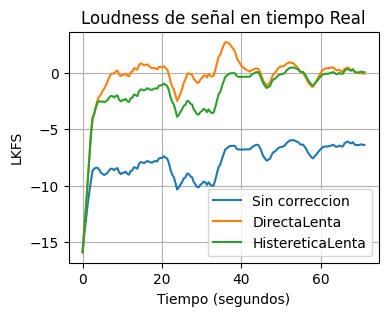

In [147]:
# Otro ejemplo con una señal mas larga
# Mercho - Lilcake
analysis = ["Sin correccion","DirectaLenta","HistereticaLenta"]
graphs = ["Loudness_Relativo","Ganancias_Aplicadas","Loudness_Correccion"]
plot_comparacion("Muestras Audio/Muestra3 - 10db atenuacion.mp3",graphs,analysis,loudness_target=77.48) ## Equivale a la señal origininal 6db atenuada

Como resultados vemos una respuesta muy centrada y con poca distorcion ya que la ganancia se mantiene constante una vez establecida. En este caso la pista es bastante favorable ya que aparenta no tener cambios muy bruzcos en el nivel de loudness a lo largo de la cancion.


<h2>Distorcion total debido a correccion de loudness</h2>

Como pudimos observar este metodo busca aplicar una ganancia a una señal para ajustar su nivel de loudness segun lo configurado. Para aplicaciones como la industria de la musica en streaming en donde las paginas obligan a los artista a subir sus cancion con un nivel de loudness determinado esto no implica un problema, ya que en la gran mayoria de los casos el nivel de loudness sera constante. Esto permite que la correccion sea lineal y no se requiera variar la ganancia constantemente a lo largo de la cancion. 
Sin embargo hay casos donde esto no se cumple y la cancion tienen niveles de loudness distintos a lo largo del tema. Si estas variaciones son los suficientemente grandes entonces el algoritmo de correccion intentara solucionar esas variaciones ajustando la ganancia.
Este problema causara una distorcion en la cancion respecto del tema original y es en este apartado donde se intentara cuantificar esa variacion para distintos caso. 
Sin embargo es importante entender que el comportamiento variara entre temas por lo que es imposible hacer un analisis exacto para todos los casos.


<h2>Deteccion de varios canales</h2>

Como se menciono al comienzo el algoritmo es capaz de medir el nivel de loudness de una señal con hasta 5 canales. Esto permite tener en consideracion sistemas mucho mas complejos donde la correccion no puede ser implementada con la medicion de un unico canal.
Es importante entender que realizar este procedimiento implica un mayor costo computacional y de memoria, por lo que para determinadas aplicacion puede no resultar recomendable aplicar el algoritmo completo.



In [154]:
import warnings
import numpy as np
from scipy.signal import lfilter

def loudness_algoritmo_multiChannel(buffer,loudness_deseado,fs = 48000,Tg_f = 0.4): 
    '''    
    Parameters
    ----------
    buffer : float
        Matriz con datos de la señal de audio a procesar. Cada fila implica un canal distinto
    loudness_deseado : float 
        Loudness deseado en dB
    fs : frecuencia de muestreo, optional
        Frecuencia a la que fue muestreado el sistema. The default is 48000.
    Tg : float, optional
        Tiempo de compuerta. The default is 0.4'

    Returns
    Valor de loudness relativo al valor deseado.
    -------
    TYPE
        Funcion que recibe un buffer de "N x Canales" muestras a una frecuencia de muestreo "Fs"
        tiempo de gate y el loudness deseado. 
        Devuelve el loudness relativo respecto al loduness deseado
    '''
    
    #Verifico si se esta analizando un canal o varios
    if buffer.ndim == 1:
        buffer = buffer.reshape(1,-1) # Un unico canal dimensiono a matriz para que funcione el algoritmo

    num_channels,num_samples = buffer.shape 

    ### Parametros para algoritmo
    T_f = num_samples/ fs ## Periodo completo de la señal
    overlap = 0.75
    step = 1 - overlap
    number_of_windows =int((T_f - Tg_f)/(Tg_f*step))  
    GI= [1,1,1,1.41,1.41] # coeficientes de los canales
    gama_a = -70 # LKFS
        
    out = np.zeros((num_channels,num_samples)) # Genero matiz donde guardo los resultados del filtrado
    
    ### Coeficientes de filtros
    
    num_preFilter= [1.53512485958697,-2.69169618940638,1.19839281085285]
    den_preFilter= [1,-1.69065929318241,0.73248077421585]

    num_weightingFilter= [1,-2,1]
    den_weightingFilter= [1,-1.99004745483398,0.99007225036621]
    
    ### Aplico filtros al buffer de X canales
    for channel in range(num_channels):
        out[channel] = lfilter(num_preFilter, den_preFilter, buffer[channel])
        out[channel] = lfilter(num_weightingFilter, den_weightingFilter, out[channel])

    ### Calculo la potencia de cada ventana para cada canal
        
    z_ij = np.zeros((num_channels,number_of_windows))  # Genero matiz donde guardo los valores de las ventanas  
    
    for channel in range(num_channels):
        integral_ij = np.array([ np.sum(out[channel][ int(Tg_f*fs*(j*step)) : int(Tg_f*fs*(j*step+1) + 1)]**2) for j in range(0,number_of_windows)]) 
        z_ij[channel] = ((1/(Tg_f*fs)) * integral_ij)
    
    ### Calculo el loudness de cada ventana
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)    
        loudness_j = -0.691 + 10*np.log10( np.sum([GI[i] * z_ij[i,j] for i in range(num_channels)],axis = 0) ) # Axis = 0 suma en forma de columnas
    
    ### Identifico muestras por encima del nivel minimo
    
    posiciones_validas = np.where(loudness_j > gama_a)
    
    ### Calculo el loudness absoluto
    
    Jg_mod = len(posiciones_validas[0])
    primer_suma = np.sum(z_ij,axis = 0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_abs = -0.695 + 10* np.log10( np.sum(primer_suma[posiciones_validas])/Jg_mod ) 
    
    ### Calculo coeficiente para el calculo de loudness relativo
    
    gama_b = loudness_abs - 10
    
    ### Identifico muestras por encima del nivel minimo
    
    posiciones_validas = np.where(loudness_j > gama_b)
    Jg_mod = len(posiciones_validas[0])
    
    ### Calculo el loudness Relativo
    
    primer_suma = np.sum(z_ij,axis = 0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_relativo = -0.695 + 10* np.log10( np.sum(primer_suma[posiciones_validas])/Jg_mod ) - loudness_deseado
    
    return loudness_relativo
    

<h2>Optimizacion codigo para dispositivos de menor capacidad</h2>

A continuacion se hace una optimizacion para poder correr el algoritmo de loudness en un microcontrolador.


In [ ]:
import numpy as np
from scipy.signal import lfilter
import warnings

def insert_subWindows_micro(data_to_insert, buffer,fs = 48000):
        ### Coeficientes de filtros
    num_preFilter= [1.53512485958697,-2.69169618940638,1.19839281085285]
    den_preFilter= [1,-1.69065929318241,0.73248077421585]

    num_weightingFilter= [1,-2,1]
    den_weightingFilter= [1,-1.99004745483398,0.99007225036621]
        
    ##Aplico filtros al buffer
    out = lfilter(num_preFilter, den_preFilter, data_to_insert)
    out = lfilter(num_weightingFilter, den_weightingFilter, out)
    
    ## Obtengo las 4 subventanas de las muestras (Tg) pasadas
    largo = len(out)
    step = 0.25
    
    for j in range(4):
        subWindow = np.sum(out[int(largo(j*step)) : int(largo*(j*step+1) + 1)]**2)
        buffer.append(subWindow)
    

def loudness_algoritmo_micro(buffer,new_gate ,loudness_deseado,fs = 48000,Tg_f = 0.4): 
    '''
    Parameters
    ----------
    buffer : float
    Vector con subventanas del 25% de Tg cada una
    loudness_deseado : float 
        Loudness deseado en dB
    fs : frecuencia de muestreo, optional
        Frecuencia a la que fue muestreado el sistema. The default is 48000.
    Tg : float, optional
        Tiempo de compuerta. The default is 0.4'

    Returns
    Valor de loudness relativo al valor deseado.
    -------
    TYPE
        Funcion que recibe un buffer de "N" muestras a una frecuencia de muestreo "Fs"
        tiempo de gate y el loudness deseado. 
        Devuelve el loudness relativo respecto al loudness deseado
    '''
        


    ### Parametros para algoritmo
    
    T_f = len(buffer)*Tg*4 ## Periodo completo de la señal
    Tg_windows = 4
    overlap = 0.75
    step = 1 - overlap
    number_of_windows =int((T_f - Tg_f)/(Tg_f*step))  
    GI= [1,1,1,1.41,1.41] # coeficientes de los canales
    
    gama_a = -70 # LKFS
    
 
     
    ## Calculo la potencia de cada ventana
    integral_ij = np.array([ np.sum(buffer[ int(Tg_windows*(j*step)) : int(Tg_windows*(j*step+1) + 1)]**2) for j in range(0,number_of_windows)]) 
    z_ij = (1/(Tg_f*fs)) * integral_ij
    
    ## Calculo el loudness de cada ventana
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_j = -0.691 + 10*np.log10( z_ij )
    
    ## Identifico muestras por encima del nivel minimo
    posiciones_validas = np.where(loudness_j > gama_a)
    
    ## Calculo el loudness absoluto
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_abs = -0.695 + 10* np.log10(np.sum(z_ij[posiciones_validas])/len(posiciones_validas[0])) 
    
    ## Calculo coeficiente para el calculo de loudness relativo
    gama_b = loudness_abs - 10
    
    ## Identifico muestras por encima del nivel minimo
    posiciones_validas = np.where(loudness_j > gama_b)
     
    ## Calculo el loudness Relativo
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_rel = -0.695 + 10* np.log10(np.sum(z_ij[posiciones_validas])/len(posiciones_validas[0])) - loudness_deseado
        
    return loudness_rel

In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import numpy as np
from scipy.signal import lfilter
import warnings
from pydub import AudioSegment
from collections import deque
import matplotlib.pyplot as plt

T = 3 # seg
Tg = 0.4 # seg
size_buff = int( 4*T/Tg )
buffer = deque(maxlen= size_buff) 


def loudness_algoritmo_micro(data_to_insert ,loudness_deseado,fs = 48000,Tg_f = 0.4): 
    '''
    Parameters
    ----------
    loudness_deseado : float 
        Loudness deseado en dB
    fs : frecuencia de muestreo, optional
        Frecuencia a la que fue muestreado el sistema. The default is 48000.
    Tg : float, optional
        Tiempo de compuerta. The default is 0.4'

    Returns
    Valor de loudness relativo al valor deseado.
    -------
    TYPE
        Funcion que recibe un buffer de "N" muestras a una frecuencia de muestreo "Fs"
        tiempo de gate y el loudness deseado. 
        Devuelve el loudness relativo respecto al loudness deseado
    '''
        

        ### Coeficientes de filtros
    num_preFilter= [1.53512485958697,-2.69169618940638,1.19839281085285]
    den_preFilter= [1,-1.69065929318241,0.73248077421585]

    num_weightingFilter= [1,-2,1]
    den_weightingFilter= [1,-1.99004745483398,0.99007225036621]
        
    ##Aplico filtros al buffer
    out = lfilter(num_preFilter, den_preFilter, data_to_insert)
    out = lfilter(num_weightingFilter, den_weightingFilter, out)
    
    ## Obtengo las 4 subventanas de las muestras (Tg) pasadas
    largo = len(out)
    step = 0.25
    
    for j in range(4):
        subWindow = np.sum(out[int(largo(j*step)) : int(largo*(j*step+1) + 1)]**2)
        buffer.append(subWindow)
    ### Parametros para algoritmo
    if len(buffer)< size_buff-1:
           return 0,0
    
    T_f = len(buffer)*Tg*4 ## Periodo completo de la señal
    step_sw = 4
    number_of_windows =int(T_f/(Tg_f * step)) 
    
    gama_a = -70 # LKFS
    
 
    ## Calculo la potencia de cada ventana
    integral_ij = np.array([ np.sum(buffer[ j : j+step_sw+ 1]) for j in range(0,number_of_windows)]) 
    z_ij = (1/(Tg_f*fs)) * integral_ij
    
    ## Calculo el loudness de cada ventana
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_j = -0.691 + 10*np.log10( z_ij )
    
    ## Identifico muestras por encima del nivel minimo
    posiciones_validas = np.where(loudness_j > gama_a)
    
    ## Calculo el loudness absoluto
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_abs = -0.695 + 10* np.log10(np.sum(z_ij[posiciones_validas])/len(posiciones_validas[0])) 
    
    ## Calculo coeficiente para el calculo de loudness relativo
    gama_b = loudness_abs - 10
    
    ## Identifico muestras por encima del nivel minimo
    posiciones_validas = np.where(loudness_j > gama_b)
     
    ## Calculo el loudness Relativo
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        loudness_rel = -0.695 + 10* np.log10(np.sum(z_ij[posiciones_validas])/len(posiciones_validas[0])) - loudness_deseado
        
    return loudness_rel, 1 ## segundo parametro indica buffer completo



def analyse_signal_realTime_micro(name,loudness_target):
    

    sample_rate = 48000  # Sample rate en Hz (48 kHz)
    
    audio = AudioSegment.from_mp3(name)

    frecuencia_muestreo = audio.frame_rate
    if frecuencia_muestreo != sample_rate:
        print(frecuencia_muestreo)
        return False

    bytes_por_muestra = audio.sample_width ## Cuanto bytes tiene cada muestra 

    duracion_total = audio.duration_seconds

    ### Buffer donde almaceno todos los samples
    buffer_loudness = []
    
    i=0
    
    while i*Tg < duracion_total:

        # Corta el segmento de audio en 0.4 segundos (simulo el real time)
        segmento = audio[i*Tg*1000:(i+1)*Tg*1000]# extraigo una ventana de 0,4 segundos 

        i +=1

        muestra_bytes = segmento.split_to_mono()[0].raw_data

        for i2 in range(0, len(muestra_bytes), bytes_por_muestra): # Los datos son de 16bits y hay que guardarlos en un buffer

            # Desempaquetar los bytes en un valor entero con signo y Agregar la muestra a la lista
            data_to_insert = float(int.from_bytes(muestra_bytes[i2:i2+bytes_por_muestra], byteorder='little', signed=True))
            loudnes_relativo, flag = loudness_algoritmo_micro(data_to_insert, loudness_target) 

        ## No mido Loudness hasta que el buffer este lleno

        if flag == 0:
            continue
        
        buffer_loudness.append(loudnes_relativo)
        
        #print(f"El valor de loudness rel={loudnes_relativo} ")

    time_captured = np.linspace(0,duracion_total,len(buffer_loudness))# en segundos
    
    return time_captured,buffer_loudness



time, data = analyse_signal_realTime_micro("Muestras Audio/Muestra1 - 4db atenuacion.mp3",loudness_target = 0 )

    # Graficar el vector buffer_gains en función del tiempo
plt.plot(time, data, label='dB')

plt.title('Loudness de señal en tiempo Real')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('LKFS')


# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.ylim(-35, 15)
plt.show()

C:\Users\paula\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\paula\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado